In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn

#Split data into test and train
from sklearn.model_selection import train_test_split

#Scaling variables
from sklearn.preprocessing import MinMaxScaler

#Build linear regression models
import statsmodels.api as sm

#To calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#To calculate R squared value
from sklearn.metrics import r2_score

### **Importing data from CSV and checking the columns against the data dictionary**

In [3]:
data = pd.read_csv('day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


(730, 16)

### We can see from the above that:
- There are **730 rows** in the dataset
- There are **0 null rows**
- There are **16 columns** in the dataset

### **Data Dictionary**

* **instant**: record index
* **dteday** : date
* **season** : season (1:spring, 2:summer, 3:fall, 4:winter)
* **yr** : year (0: 2018, 1:2019)
* **mnth** : month ( 1 to 12)
* **holiday** : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
* **weekday** : day of the week
* **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
* **weathersit** : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **temp** : temperature in Celsius
* **atemp**: feeling temperature in Celsius
* **hum**: humidity
* **windspeed**: wind speed
* **casual**: count of casual users
* **registered**: count of registered users
* **cnt**: count of total rental bikes including both casual and registered

In [5]:
# Mapping of various col values as per data dictionary

map_dict = {
    'yr'   : {'0':'2018','1':'2019'},
    'season' : {'1':'spring', '2':'summer', '3':'fall', '4':'winter'},
    'mnth'       : {'1':'Jan', '2':'Feb', '3':'Mar', '4':'Apr', '5':'May', '6':'Jun', '7':'Jul', '8':'Aug', '9':'Sep', '10':'Oct', '11':'Nov', '12':'Dec'},
    'weekday'    : {'0': 'Tue','1':'Wed','2':'Thu', '3': 'Fri', '4': 'Sat', '5': 'Sun', '6': 'Mon'},
    'weathersit' : {'1':'Clear', '2': 'Cloudy', '3': 'Light Rain', '4': 'Heavy Rain'}
}
 

### **Problem Statement**

Develop a model to understand the factors affecting the demand for shared bikes in the American market based on the data provided.
The company wants to know:
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands

Target variable is **"cnt"**

### **Data Quality Checks and Cleanup**

- ### Since our target variable is **cnt** we do not need **registered** and **casual** users
- ### Since **instant** is the record index and has no impact on the demand of the bikes, we can drop it
- ### Since we have **yr**,**mnth**,**weekday**; we don't need **dteday** for this analysis

In [6]:
data.drop(['casual', 'registered', 'instant', 'dteday'], inplace=True, axis = 1)

In [7]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Convert **mnth, season, weekday, weathersit** to string dtype as they are categorical variables

In [8]:
data[['mnth','season','weekday','weathersit']] = data[['mnth','season','weekday','weathersit']].astype(str)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [10]:
# Method to map number codes in the data to their string values
def map_code_to_str(col):
    return data[col].map(map_dict[col])

In [11]:
# converting season, mnth, weathersit, weekday to string values using the data disctionary
data['season'] = map_code_to_str('season')
data['mnth'] = map_code_to_str('mnth')
data['weathersit'] = map_code_to_str('weathersit')
data['weekday'] = map_code_to_str('weekday')

In [12]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,0,Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,0,Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [13]:
# Validate if any NaN values after replacement
data.info()
data[['season', 'mnth', 'weathersit']].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


season        0
mnth          0
weathersit    0
dtype: int64

**The above validation confirms that all values are replaced properly**

In [14]:
# Understanding the range and scale of data
data.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


### Visual Analysis of continuous variables from Data and qualitative validation of possibility of a Linear Regression Model

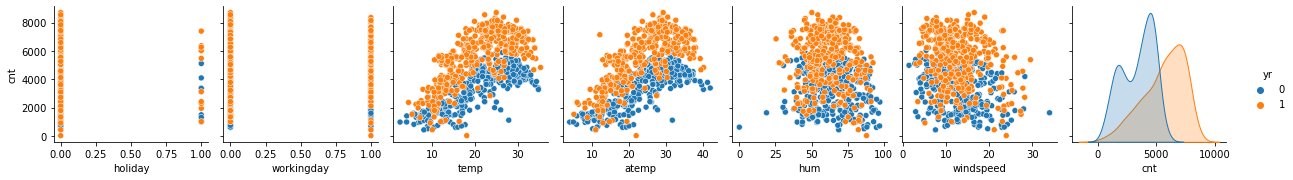

In [15]:
# Pairplot against 'cnt' to check if a linear relationship is visible
sns.pairplot(data, y_vars=['cnt'] , hue='yr')
plt.show()

**Conclusion:** The plots *temp vs cnt* and *atemp vs cnt* show a clear linear relationship, hence a ***Linear Regression Model is possible***

**Additional Observations:**

* temp and atemp show a very similar impact on cnt. It is highly likely that they are correlated
* There are clearlt more data points for 2019, hence we can say that cnt/demand is higher for 2019 which aligns with the thought process that the bike renting platform is getting more and more popular in America with time


### Identifying Correlations in independent variables

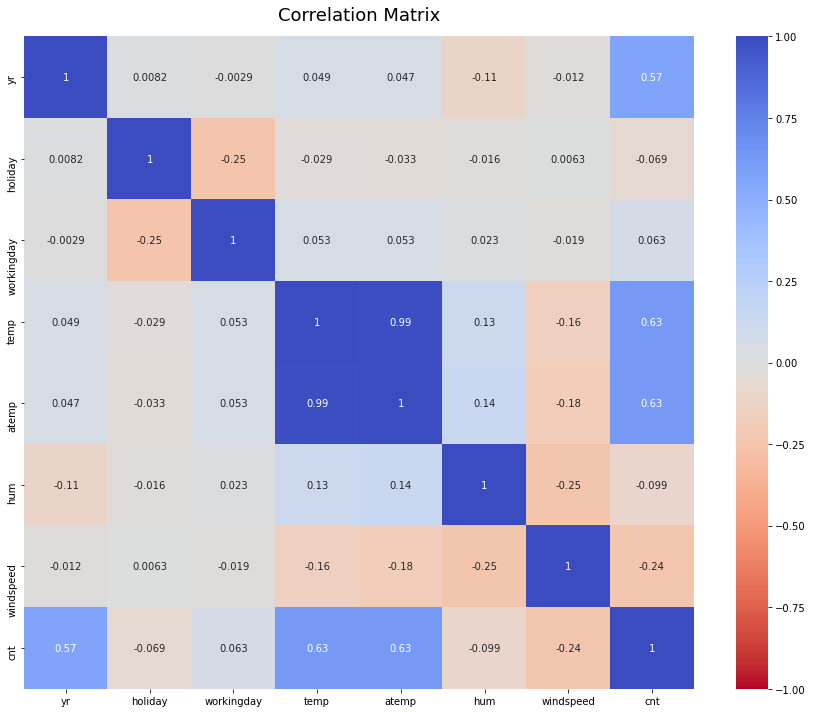

In [16]:
#Correlation Matrix
plt.figure(figsize=(15,12))
corr_plot = sns.heatmap(data.corr(), cmap='coolwarm_r', vmin=-1, vmax=1, annot=True)
corr_plot.set_title('Correlation Matrix', fontdict={'fontsize':18}, pad=16);
plt.show(corr_plot)

**Observations:**

* temp and atemp are highly correlated
* temp and a temp are positively correlated with cnt; this is aligned with common logic that people avoid riding bikes during cold days
* windspeed is negatively correlated with cnt; this validates the common logic that it's difficult to ride bikes on windy days


### Visual Analysis of categorical variables from Data

In [17]:
def draw_boxplot(x_var, y_var='cnt', df=data):
    return sns.boxplot(x=x_var,y=y_var, data=df)

def draw_barplot(x_var, y_var='cnt', df=data):
    return sns.barplot(x=x_var, y=y_var, data=df)

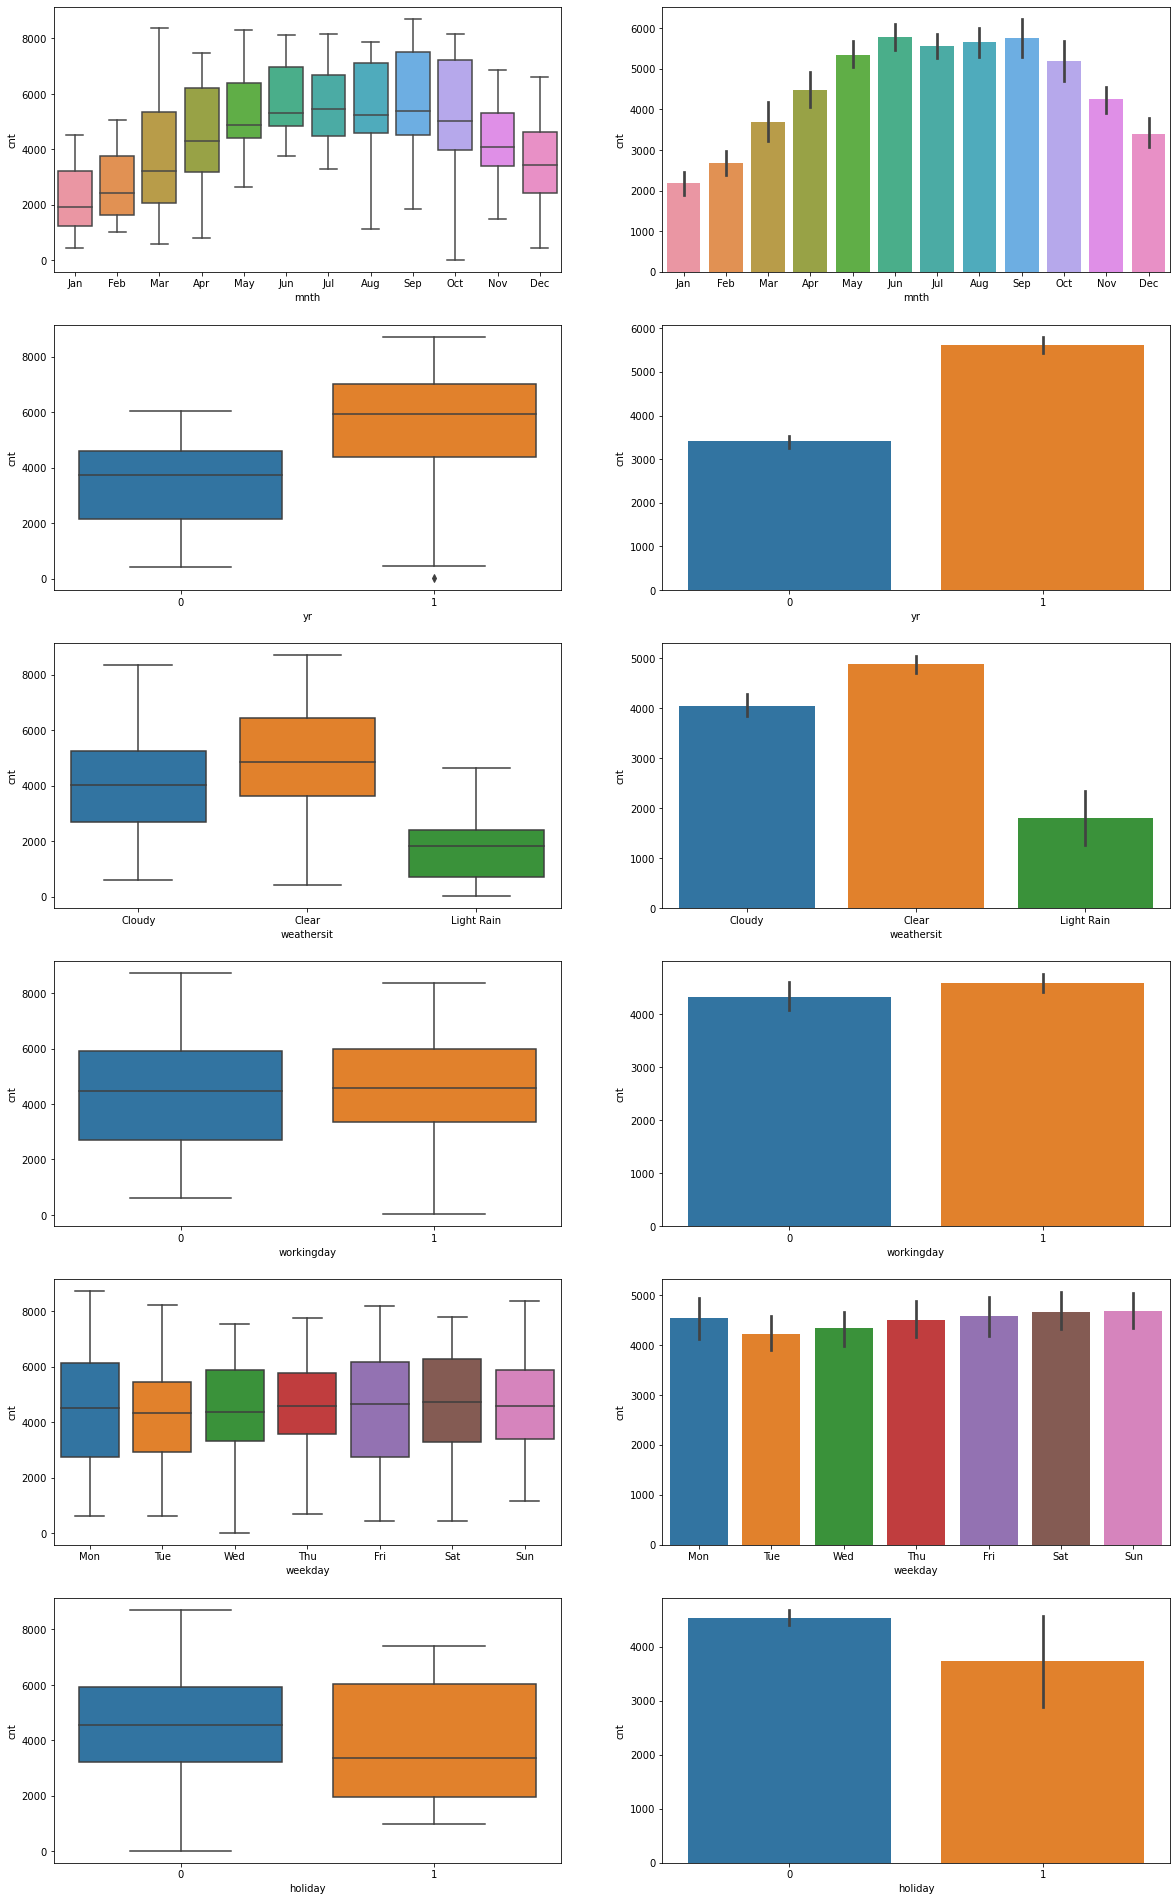

In [18]:
# Plotting boxplot and barplot side-by-side for each categorical variable to understand the pattern
plt.figure(figsize=(20, 40))

plt.subplot(7,2,1)
draw_boxplot('season','cnt', data)

plt.subplot(3,3,2)
draw_barplot('season','cnt', data)


plt.subplot(7,2,3)
draw_boxplot('mnth','cnt', data)

plt.subplot(7,2,4)
draw_barplot('mnth','cnt', data)



plt.subplot(7,2,5)
draw_boxplot('yr','cnt', data)

plt.subplot(7,2,6)
draw_barplot('yr','cnt', data)


plt.subplot(7,2,7)
draw_boxplot('weathersit','cnt', data)

plt.subplot(7,2,8)
draw_barplot('weathersit','cnt', data)


plt.subplot(7,2,9)
draw_boxplot('workingday','cnt', data)

plt.subplot(7,2,10)
draw_barplot('workingday','cnt', data)


plt.subplot(7,2,11)
draw_boxplot('weekday','cnt', data)

plt.subplot(7,2,12)
draw_barplot('weekday','cnt', data)


plt.subplot(7,2,13)
draw_boxplot('holiday','cnt', data)

plt.subplot(7,2,14)
draw_barplot('holiday','cnt', data)

plt.show()

**Observations:**

* Demand for rented bikes is fairly high from May to Oct months which belong in Summer and Fall seasons
* As observed earlier, demand in 2019 was way higher than 2018
* Demand is fairly high during clear and cloudy weather. There is no demand during heavy rain/snowfall
* Demand is slighly higher during workingdays as compared to non-workingdays. The inverse is applicable for holidays where demand reduces during holidays
* There's not much variation in demand per days of the week. But the highest demand is on Monday (6)

### **Converting Categorical Variables to Dummy Variables**

In [19]:
# copy data to a new variable data_new
data_new = data

In [20]:
data_new.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Mon,0,Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,0,Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thu,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [21]:
# Generating Dummy variables for categorical variables and ignore the first dummy
# Drop original variables

data_new = pd.get_dummies(data_new, drop_first=True)
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   atemp                  730 non-null    float64
 5   hum                    730 non-null    float64
 6   windspeed              730 non-null    float64
 7   cnt                    730 non-null    int64  
 8   season_spring          730 non-null    uint8  
 9   season_summer          730 non-null    uint8  
 10  season_winter          730 non-null    uint8  
 11  mnth_Aug               730 non-null    uint8  
 12  mnth_Dec               730 non-null    uint8  
 13  mnth_Feb               730 non-null    uint8  
 14  mnth_Jan               730 non-null    uint8  
 15  mnth_J

In [22]:
pd.set_option('display.max_columns', None)
data_new.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Light Rain
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   atemp                  730 non-null    float64
 5   hum                    730 non-null    float64
 6   windspeed              730 non-null    float64
 7   cnt                    730 non-null    int64  
 8   season_spring          730 non-null    uint8  
 9   season_summer          730 non-null    uint8  
 10  season_winter          730 non-null    uint8  
 11  mnth_Aug               730 non-null    uint8  
 12  mnth_Dec               730 non-null    uint8  
 13  mnth_Feb               730 non-null    uint8  
 14  mnth_Jan               730 non-null    uint8  
 15  mnth_J

### We can see that all the categorical variables have been converted to dummy encoded variables.
### Now we can split the data into test/train sets and check if scaling is needed

### **Splitting the data into Train and Test Dataset**

In [24]:
# Split data_new into test and train data.
# Approach is to train the model using 70% of the data and then validate/test using the remaining 30%

data_new_train, data_new_test = train_test_split(data_new, train_size=0.7, random_state=50)
print("Test Shape:",data_new_test.shape)
print("Train Shape:",data_new_train.shape)

Test Shape: (220, 30)
Train Shape: (510, 30)


### **Scaling the variables**

In [25]:
# Checking the scale/distribution of variables
print("============================================")
print("================Max Values==================")
print("============================================")
print(data_new_train.max())
print("============================================")
print("=================Min Values=================")
print("============================================")
print(data_new_train.min())
print("============================================")

================Max Values==================
yr                          1.000000
holiday                     1.000000
workingday                  1.000000
temp                       34.371653
atemp                      39.741450
hum                        97.041700
windspeed                  34.000021
cnt                      8714.000000
season_spring               1.000000
season_summer               1.000000
season_winter               1.000000
mnth_Aug                    1.000000
mnth_Dec                    1.000000
mnth_Feb                    1.000000
mnth_Jan                    1.000000
mnth_Jul                    1.000000
mnth_Jun                    1.000000
mnth_Mar                    1.000000
mnth_May                    1.000000
mnth_Nov                    1.000000
mnth_Oct                    1.000000
mnth_Sep                    1.000000
weekday_Mon                 1.000000
weekday_Sat                 1.000000
weekday_Sun                 1.000000
weekday_Thu                 1.

#### **Observation**
**temp**, **atemp**, **windspeed**, **hum** and **cnt** are the variables with high values and need to be scaled down to ensure that all coefficients are also relatively in the same range


**To scale the variables we will use MinMax scaling method to reduce the values of the above variables to lie between 0 and 1**

In [26]:
# Creating an instance of MinMaxscaler
scaler = MinMaxScaler()

In [27]:
# scaling variables identified above "large_vars"
large_vars = ['temp', 'atemp', 'windspeed', 'hum', 'cnt']
data_new_train[large_vars] = scaler.fit_transform(data_new_train[large_vars])

In [28]:
data_new_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Light Rain
172,0,0,1,0.865247,0.858891,0.729068,0.274549,0.515992,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0.223565,0.236172,0.513954,0.243603,0.141049,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
204,0,0,0,0.989306,1.000000,0.567625,0.267859,0.412333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
182,0,0,0,0.871664,0.821838,0.458136,0.150755,0.586401,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
708,1,0,1,0.483446,0.498080,0.953198,0.313605,0.592269,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [29]:
# Re-checking the scale/distribution of variables
print("============================================")
print("================Max Values==================")
print("============================================")
print(data_new_train.max())
print("============================================")
print("=================Min Values=================")
print("============================================")
print(data_new_train.min())
print("============================================")

================Max Values==================
yr                       1.0
holiday                  1.0
workingday               1.0
temp                     1.0
atemp                    1.0
hum                      1.0
windspeed                1.0
cnt                      1.0
season_spring            1.0
season_summer            1.0
season_winter            1.0
mnth_Aug                 1.0
mnth_Dec                 1.0
mnth_Feb                 1.0
mnth_Jan                 1.0
mnth_Jul                 1.0
mnth_Jun                 1.0
mnth_Mar                 1.0
mnth_May                 1.0
mnth_Nov                 1.0
mnth_Oct                 1.0
mnth_Sep                 1.0
weekday_Mon              1.0
weekday_Sat              1.0
weekday_Sun              1.0
weekday_Thu              1.0
weekday_Tue              1.0
weekday_Wed              1.0
weathersit_Cloudy        1.0
weathersit_Light Rain    1.0
dtype: float64
=================Min Values=================
yr                       

#### **Observation**
All columns in the training dataset are to scale. We can start building the model now

### **Building a Model**

#### We have 29 features which need to be considered to model demand for renting bikes.
#### We can consider a top-down approach where we start by building a model with all variables and then eliminate the variables based on the following
#### **Approach:**
##### - Eliminate variables where p values are greater than 0.05
##### - Eliminate variables where VIF is greater than 5
##### - Cases where both high p-val and high VIF exists, we will first eliminate features with high p-val as it will have an impact on VIF which can be evaluated in the next iteration

In [30]:
# Dividing training data into X (independent) and Y (target values) datasets 
y_train = data_new_train.pop('cnt')
X_train = data_new_train

In [31]:
# Since statsmodel does not add an intercept to the linear regression model by default, we need to manually add the constant

X_train_lm = sm.add_constant(X_train)

In [32]:
X_train_lm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Light Rain
172,1.0,0,0,1,0.865247,0.858891,0.729068,0.274549,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.0,0,0,0,0.223565,0.236172,0.513954,0.243603,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
204,1.0,0,0,0,0.989306,1.000000,0.567625,0.267859,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
182,1.0,0,0,0,0.871664,0.821838,0.458136,0.150755,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
708,1.0,1,0,1,0.483446,0.498080,0.953198,0.313605,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


#### We can see that a constant column with value 1.0 is added to the dataset

#### **Building the Initial model with all features**

### **OLS Regression**

In [33]:
lr_0 = sm.OLS(y_train, X_train_lm).fit()
print(lr_0.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     103.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.48e-184
Time:                        07:01:51   Log-Likelihood:                 538.59
No. Observations:                 510   AIC:                            -1019.
Df Residuals:                     481   BIC:                            -896.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

### **VIF Calculation**
This is to understand and eliminate multicolinearity

In [34]:
# Function to get VIF for the X_train provided
def get_VIF(XTrain):
    vif = pd.DataFrame()
    vif['Features'] = XTrain.columns
    vif['VIF'] = [variance_inflation_factor(XTrain.values, i) for i in range(XTrain.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [35]:
get_VIF(X_train)

,Features,VIF
2,workingday,95.84
3,temp,66.04
4,atemp,56.18
21,weekday_Mon,18.45
25,weekday_Tue,17.74
7,season_spring,11.18
9,season_winter,10.96
8,season_summer,7.97
18,mnth_Nov,7.37
19,mnth_Oct,6.81


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Aug** with **p-value=0.928**

### **Action**
**Drop *mnth_Aug*** and run another iteration

In [36]:
#Droping 'mnth_Aug' from the training data
X = X_train.drop('mnth_Aug', 1,)

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 172 to 688
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     510 non-null    int64  
 1   holiday                510 non-null    int64  
 2   workingday             510 non-null    int64  
 3   temp                   510 non-null    float64
 4   atemp                  510 non-null    float64
 5   hum                    510 non-null    float64
 6   windspeed              510 non-null    float64
 7   season_spring          510 non-null    uint8  
 8   season_summer          510 non-null    uint8  
 9   season_winter          510 non-null    uint8  
 10  mnth_Dec               510 non-null    uint8  
 11  mnth_Feb               510 non-null    uint8  
 12  mnth_Jan               510 non-null    uint8  
 13  mnth_Jul               510 non-null    uint8  
 14  mnth_Jun               510 non-null    uint8  
 15  mnth

In [38]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 1: Building the Next model**

### **OLS Regression**

In [39]:
lr_1 = sm.OLS(y_train, X_train_lm).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     107.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.25e-185
Time:                        07:01:51   Log-Likelihood:                 538.59
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     482   BIC:                            -902.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [40]:
get_VIF(X)

,Features,VIF
2,workingday,79.52
3,temp,62.18
4,atemp,54.75
20,weekday_Mon,14.96
24,weekday_Tue,14.65
9,season_winter,10.02
7,season_spring,9.19
17,mnth_Nov,6.44
10,mnth_Dec,5.89
18,mnth_Oct,5.61


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Mar** with **p-value=0.969**

### **Action**
**Drop *mnth_Mar*** and run another iteration

In [41]:
#Droping 'mnth_Mar' from the training data
X = X.drop('mnth_Mar', 1,)

In [42]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 2: Building the Next model**

### **OLS Regression**

In [43]:
lr_2 = sm.OLS(y_train, X_train_lm).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     112.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          4.91e-186
Time:                        07:01:52   Log-Likelihood:                 538.58
No. Observations:                 510   AIC:                            -1023.
Df Residuals:                     483   BIC:                            -908.8
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [44]:
get_VIF(X)

,Features,VIF
2,workingday,72.47
3,temp,60.95
4,atemp,54.68
19,weekday_Mon,13.71
23,weekday_Tue,13.44
9,season_winter,8.66
7,season_spring,6.30
16,mnth_Nov,4.61
17,mnth_Oct,4.19
8,season_summer,4.14


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **weekday_Sat** with **p-value=0.573**

### **Action**
**Drop *weekday_Sat*** and run another iteration

In [45]:
#Droping 'weekday_Sat' from the training data
X = X.drop('weekday_Sat', 1,)

In [46]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 3: Building the Next model**

### **OLS Regression**

In [47]:
lr_3 = sm.OLS(y_train, X_train_lm).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     116.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.27e-187
Time:                        07:01:53   Log-Likelihood:                 538.42
No. Observations:                 510   AIC:                            -1025.
Df Residuals:                     484   BIC:                            -914.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [48]:
get_VIF(X)

,Features,VIF
2,workingday,69.49
3,temp,60.95
4,atemp,54.67
19,weekday_Mon,13.70
22,weekday_Tue,13.44
9,season_winter,8.66
7,season_spring,6.29
16,mnth_Nov,4.61
17,mnth_Oct,4.19
8,season_summer,4.14


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Oct** with **p-value=0.574**

### **Action**
**Drop *mnth_Oct*** and run another iteration

In [49]:
#Droping 'mnth_Oct' from the training data
X = X.drop('mnth_Oct', 1,)

In [50]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 4: Building the Next model**

### **OLS Regression**

In [51]:
lr_4 = sm.OLS(y_train, X_train_lm).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     121.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.52e-188
Time:                        07:01:53   Log-Likelihood:                 538.25
No. Observations:                 510   AIC:                            -1027.
Df Residuals:                     485   BIC:                            -920.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [52]:
get_VIF(X)

,Features,VIF
2,workingday,69.27
3,temp,60.81
4,atemp,54.65
18,weekday_Mon,13.66
21,weekday_Tue,13.40
7,season_spring,6.25
9,season_winter,4.24
8,season_summer,4.06
1,holiday,3.58
5,hum,2.20


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **weekday_Sun** with **p-value=0.574**

### **Action**
**Drop *weekday_Sun*** and run another iteration

In [53]:
#Droping 'weekday_Sun' from the training data
X = X.drop('weekday_Sun', 1,)

In [54]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 5: Building the Next model**

### **OLS Regression**

In [55]:
lr_5 = sm.OLS(y_train, X_train_lm).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     127.2
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.23e-189
Time:                        07:01:54   Log-Likelihood:                 538.17
No. Observations:                 510   AIC:                            -1028.
Df Residuals:                     486   BIC:                            -926.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [56]:
get_VIF(X)

,Features,VIF
2,workingday,67.82
3,temp,60.40
4,atemp,54.16
18,weekday_Mon,13.65
20,weekday_Tue,13.38
7,season_spring,6.25
9,season_winter,4.23
8,season_summer,4.05
1,holiday,3.53
5,hum,2.20


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **atemp** with **p-value=0.465**

### **Action**
**Drop *atemp*** and run another iteration

In [57]:
#Droping 'atemp' from the training data
X = X.drop('atemp', 1,)

In [58]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 6: Building the Next model**

### **OLS Regression**

In [59]:
lr_6 = sm.OLS(y_train, X_train_lm).fit()
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     133.1
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.84e-190
Time:                        07:01:55   Log-Likelihood:                 537.89
No. Observations:                 510   AIC:                            -1030.
Df Residuals:                     487   BIC:                            -932.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [60]:
get_VIF(X)

,Features,VIF
2,workingday,67.75
17,weekday_Mon,13.64
19,weekday_Tue,13.38
6,season_spring,6.19
3,temp,6.13
8,season_winter,4.14
7,season_summer,3.94
1,holiday,3.52
4,hum,2.18
11,mnth_Jan,2.14


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Jul** with **p-value=0.240**

### **Action**
**Drop *mnth_Jul*** and run another iteration

In [61]:
#Droping 'mnth_Jul' from the training data
X = X.drop('mnth_Jul', 1,)

In [62]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 7: Building the Next model**

### **OLS Regression**

In [63]:
lr_7 = sm.OLS(y_train, X_train_lm).fit()
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     139.3
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          9.70e-191
Time:                        07:01:56   Log-Likelihood:                 537.16
No. Observations:                 510   AIC:                            -1030.
Df Residuals:                     488   BIC:                            -937.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.27

#### **VIF Calculation**


In [64]:
get_VIF(X)

,Features,VIF
2,workingday,67.54
16,weekday_Mon,13.58
18,weekday_Tue,13.32
6,season_spring,6.04
3,temp,5.77
8,season_winter,3.94
7,season_summer,3.79
1,holiday,3.50
4,hum,2.17
11,mnth_Jan,2.13


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Feb** with **p-value=0.120**

### **Action**
**Drop *mnth_Feb*** and run another iteration

In [65]:
#Droping 'mnth_Feb' from the training data
X = X.drop('mnth_Feb', 1,)

In [66]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 8: Building the Next model**

### **OLS Regression**

In [67]:
lr_8 = sm.OLS(y_train, X_train_lm).fit()
print(lr_8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     145.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.64e-191
Time:                        07:01:57   Log-Likelihood:                 535.90
No. Observations:                 510   AIC:                            -1030.
Df Residuals:                     489   BIC:                            -940.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.26

#### **VIF Calculation**


In [68]:
get_VIF(X)

,Features,VIF
2,workingday,64.75
15,weekday_Mon,13.07
17,weekday_Tue,12.82
6,season_spring,5.67
3,temp,5.44
8,season_winter,3.93
7,season_summer,3.70
1,holiday,3.36
4,hum,2.17
12,mnth_May,1.87


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **holiday** with **p-value=0.137**

### **Action**
**Drop *holiday*** and run another iteration

In [69]:
#Droping 'holiday' from the training data
X = X.drop('holiday', 1,)

In [70]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 9: Building the Next model**

### **OLS Regression**

In [71]:
lr_9 = sm.OLS(y_train, X_train_lm).fit()
print(lr_9.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     145.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.64e-191
Time:                        07:01:57   Log-Likelihood:                 535.90
No. Observations:                 510   AIC:                            -1030.
Df Residuals:                     489   BIC:                            -940.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.29

#### **VIF Calculation**


In [72]:
get_VIF(X)

,Features,VIF
3,hum,37.93
2,temp,24.49
1,workingday,21.83
5,season_spring,5.19
14,weekday_Mon,5.17
4,windspeed,5.09
16,weekday_Tue,5.08
7,season_winter,4.46
6,season_summer,4.02
18,weathersit_Cloudy,2.49


### **Observation**
There is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **weekday_Tue** with **p-value=0.733**

### **Action**
**Drop *weekday_Tue*** and run another iteration

In [73]:
#Droping 'weekday_Tue' from the training data
X = X.drop('weekday_Tue', 1,)

In [74]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 10: Building the Next model**

### **OLS Regression**

In [75]:
lr_10 = sm.OLS(y_train, X_train_lm).fit()
print(lr_10.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     153.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.23e-192
Time:                        07:01:58   Log-Likelihood:                 535.84
No. Observations:                 510   AIC:                            -1032.
Df Residuals:                     490   BIC:                            -947.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.30

#### **VIF Calculation**


In [76]:
get_VIF(X)

,Features,VIF
3,hum,34.32
2,temp,20.73
1,workingday,5.70
4,windspeed,4.94
5,season_spring,4.41
7,season_winter,4.03
6,season_summer,3.57
17,weathersit_Cloudy,2.45
0,yr,2.00
11,mnth_May,1.94


### **Observation**
TThere is a high amount of multicolinearity with high VIFs    
There are features with high p-values (>0.05).  
The least significant variable is **mnth_Jun** with **p-value=0.130**

### **Action**
**Drop *mnth_Jun*** and run another iteration

In [77]:
#Droping 'mnth_Jun' from the training data
X = X.drop('mnth_Jun', 1,)

In [78]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 11: Building the Next model**

### **OLS Regression**

In [79]:
lr_11 = sm.OLS(y_train, X_train_lm).fit()
print(lr_11.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     161.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          5.41e-193
Time:                        07:01:59   Log-Likelihood:                 534.64
No. Observations:                 510   AIC:                            -1031.
Df Residuals:                     491   BIC:                            -950.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.29

#### **VIF Calculation**


In [80]:
get_VIF(X)

,Features,VIF
3,hum,32.51
2,temp,18.16
1,workingday,5.70
4,windspeed,4.88
5,season_spring,4.35
7,season_winter,4.02
6,season_summer,3.13
16,weathersit_Cloudy,2.43
0,yr,1.99
13,weekday_Mon,1.87


### **Observation**
There is a high amount of multicolinearity with high VIFs  
There are features with high p-values (>0.05).  
The least significant variable is **mnth_May** with **p-value=0.240**

### **Action**
**Drop *mnth_May*** and run another iteration

In [81]:
#Droping 'mnth_May' from the training data
X = X.drop('mnth_May', 1,)

In [82]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 12: Building the Next model**

### **OLS Regression**

In [83]:
lr_12 = sm.OLS(y_train, X_train_lm).fit()
print(lr_12.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     170.9
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          8.10e-194
Time:                        07:01:59   Log-Likelihood:                 533.92
No. Observations:                 510   AIC:                            -1032.
Df Residuals:                     492   BIC:                            -955.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.28

#### **VIF Calculation**


In [84]:
get_VIF(X)

,Features,VIF
3,hum,32.15
2,temp,18.16
1,workingday,5.65
4,windspeed,4.83
5,season_spring,4.35
7,season_winter,4.01
6,season_summer,2.53
15,weathersit_Cloudy,2.43
0,yr,1.99
10,mnth_Nov,1.87


### **Observation**
There is a high amount of multicolinearity with high VIFs  
There are features with high p-values (>0.05).  
The least significant variable is **weekday_Thu** with **p-value=0.107**

### **Action**
**Drop *weekday_Thu*** and run another iteration

In [85]:
#Droping 'weekday_Thu' from the training data
X = X.drop('weekday_Thu', 1,)

In [86]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 13: Building the Next model**

### **OLS Regression**

In [87]:
lr_13 = sm.OLS(y_train, X_train_lm).fit()
print(lr_13.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     180.8
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          2.17e-194
Time:                        07:02:00   Log-Likelihood:                 532.57
No. Observations:                 510   AIC:                            -1031.
Df Residuals:                     493   BIC:                            -959.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.29

#### **VIF Calculation**


In [88]:
get_VIF(X)

,Features,VIF
3,hum,32.09
2,temp,18.14
1,workingday,5.35
4,windspeed,4.83
5,season_spring,4.34
7,season_winter,4.01
6,season_summer,2.53
14,weathersit_Cloudy,2.42
0,yr,1.98
10,mnth_Nov,1.86


### **Observation**
There is a high amount of multicolinearity with high VIFs  
There are features with high p-values (>0.05).  
The least significant variable is **weekday_Wed** with **p-value=0.066**

### **Action**
**Drop *weekday_Wed*** and run another iteration

In [89]:
#Droping 'weekday_Wed' from the training data
X = X.drop('weekday_Wed', 1,)

In [90]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 14: Building the Next model**

### **OLS Regression**

In [91]:
lr_14 = sm.OLS(y_train, X_train_lm).fit()
print(lr_14.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     191.7
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          8.24e-195
Time:                        07:02:01   Log-Likelihood:                 530.83
No. Observations:                 510   AIC:                            -1030.
Df Residuals:                     494   BIC:                            -961.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.29

#### **VIF Calculation**


In [92]:
get_VIF(X)

,Features,VIF
3,hum,32.03
2,temp,18.14
1,workingday,5.33
4,windspeed,4.83
5,season_spring,4.34
7,season_winter,4.01
6,season_summer,2.53
13,weathersit_Cloudy,2.42
0,yr,1.98
10,mnth_Nov,1.86


### **Observation**
All features have p-values less than 0.05 thus are statistically significant 

There is a high amount of multicolinearity with high VIFs.  
 
The variable with highest multicolinearity is **hum** with **VIF=32.03**

### **Action**
**Drop *hum*** and run another iteration

In [93]:
#Droping 'hum' from the training data
X = X.drop('hum', 1,)

In [94]:
# Adding Constant
X_train_lm = sm.add_constant(X)

#### **Iteration 15: Building the Next model**

### **OLS Regression**

In [95]:
lr_15 = sm.OLS(y_train, X_train_lm).fit()
print(lr_15.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.6
Date:                Wed, 12 Jan 2022   Prob (F-statistic):          1.79e-189
Time:                        07:02:01   Log-Likelihood:                 515.34
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     495   BIC:                            -937.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.20

#### **VIF Calculation**


In [96]:
get_VIF(X)

,Features,VIF
2,temp,5.87
1,workingday,5.27
3,windspeed,4.70
6,season_winter,2.92
4,season_spring,2.85
5,season_summer,2.05
0,yr,1.96
11,weekday_Mon,1.81
9,mnth_Nov,1.80
12,weathersit_Cloudy,1.60


### **Observation**
All features have p-values less than 0.05 thus are statistically significant  
There is a low/no multicolinearity with all VIFs under 10.  
This model has all p-values and VIF values in range thus we will consider this model to test further.

Model **lr_15** will be used to validate the assumptions of linear regression

In [97]:
#List coeff for the model
round(lr_15.params,3)

const                    0.204
yr                       0.237
workingday               0.039
temp                     0.421
windspeed               -0.152
season_spring           -0.076
season_summer            0.044
season_winter            0.107
mnth_Dec                -0.055
mnth_Jan                -0.049
mnth_Nov                -0.064
mnth_Sep                 0.056
weekday_Mon              0.055
weathersit_Cloudy       -0.080
weathersit_Light Rain   -0.275
dtype: float64

### **Validating the assumptions of Linear Regression (Residual Analysis)**

#### **1. Errors are Normally distributed**

In [98]:
# predicted values of y_train using model lr_15
y_train_pred = lr_15.predict(X_train_lm)

Text(0.5, 0, 'Errors')

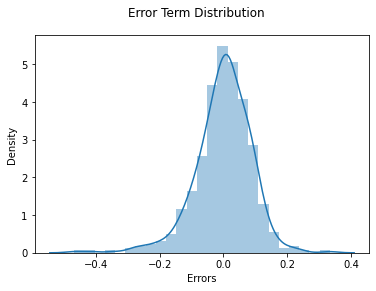

In [99]:
# Histogram of the error terms
hist = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 25)
hist.suptitle('Error Term Distribution')
plt.xlabel('Errors')

#### **Observation:**
#### The Error Terms are normally distributed with mean at 0.0

#### **2. Errors are Independent of eachother**

**Durbin-Watson** test is used to check for correlation in the errors.  
If Durbin-Watson value is between 0-2 then there is a positive correlation in the errors and if it is between 2-4 then there is a negative correlation in the errors. Values closer to 2 show no correlation.  
For **Model lr_15**,  
&emsp;**Durbin-Watson is 2.044**  
Hence, there is no correlation between the errors and they are considered independent.


#### **3. Low or no Multicolinearity**

We can check for Multicolinearity by looking at **VIF** or **Variance Inflation Factor**.  
High values of VIF signify multicolinearity or correlation among features.

* **VIF > 10 :** High Multicolinearity  
* **5 < VIF < 10 :**  Low Multicolinearity
* **VIF < 5 :** Very Low Multicolinearity

In [100]:
print(get_VIF(X))

                 Features   VIF
2                    temp  5.87
1              workingday  5.27
3               windspeed  4.70
6           season_winter  2.92
4           season_spring  2.85
5           season_summer  2.05
0                      yr  1.96
11            weekday_Mon  1.81
9                mnth_Nov  1.80
12      weathersit_Cloudy  1.60
7                mnth_Dec  1.53
8                mnth_Jan  1.50
10               mnth_Sep  1.21
13  weathersit_Light Rain  1.10


From above we can see that nearly all values are unser 5 with an exception of **temp** and **workingday** which also has low VIF.  
Hence, we can say that:  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**model lr_15 has no / low multicolinearity** 

#### **4. Errors have constant variance (Homoscedesticity)**

This can be evaluated by qualitative analysis of a scatterplot of errors vs counts. 
If a pattern can be identified, then the assumption is not satisfied.

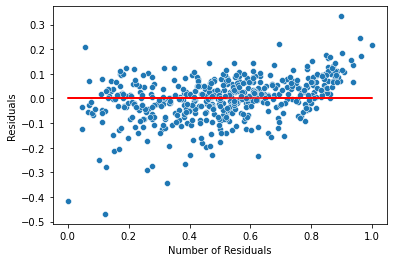

In [101]:
sns.scatterplot(y_train,(y_train - y_train_pred))
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Number of Residuals')
plt.ylabel('Residuals')
plt.show()

We can clearly see from the above graph that there is no pattern and hence the model is homoscedestic

#### **5. Linear relationship between features and target variable**

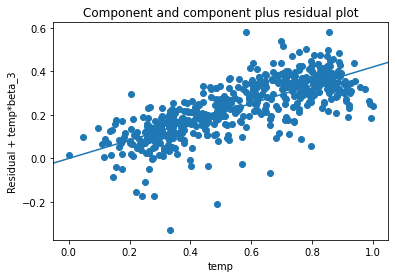

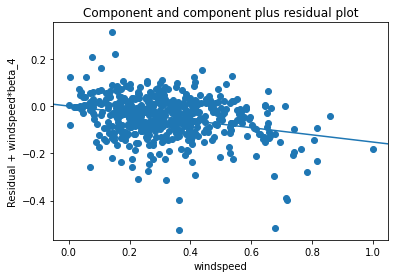

In [102]:
sm.graphics.plot_ccpr(lr_15, 'temp')
sm.graphics.plot_ccpr(lr_15, 'windspeed')
plt.show()

From the above plots, we can confirm that there is a clear linear relatinship between the independent variables and the target variable

### **Making predictions using the final model**

In [103]:
#Scaling the vars we scaled in train

scale_vars = ['temp', 'atemp', 'windspeed', 'hum', 'cnt']
data_new_test[scale_vars] = scaler.fit_transform(data_new_test[scale_vars])

In [104]:
data_new_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,weathersit_Cloudy,weathersit_Light Rain
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.540909,0.040909,0.627273,0.538703,0.520744,0.493549,0.417202,0.492679,0.250,0.245455,0.227273,0.077273,0.068182,0.077273,0.109091,0.100000,0.081818,0.063636,0.050000,0.068182,0.081818,0.122727,0.163636,0.136364,0.140909,0.122727,0.168182,0.122727,0.327273,0.022727
std,0.499460,0.198531,0.484633,0.249203,0.229757,0.204367,0.198584,0.247892,0.434,0.431338,0.420026,0.267633,0.252632,0.267633,0.312464,0.300684,0.274713,0.244661,0.218442,0.252632,0.274713,0.328872,0.370789,0.343957,0.348721,0.328872,0.374881,0.328872,0.470288,0.149373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.328245,0.342712,0.348109,0.276108,0.326670,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.550228,0.549939,0.478244,0.392387,0.488393,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.745674,0.707115,0.638702,0.535854,0.690353,0.250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
#Dividing into x_test and y_test
y_test = data_new_test.pop('cnt')
X_test = data_new_test

In [106]:
# Adding constant variable to test dataframe
X_test_lr15 = sm.add_constant(X_test)

In [107]:
# Creating X_test_lr15 dataframe by dropping variables which are insignificant
X_train_lm.columns
X_test_lr15 = X_test_lr15[X_train_lm.columns]

In [108]:
# Making predictions using the lr_15 model

y_test_pred_lr15 = lr_15.predict(X_test_lr15)
y_test_pred_lr15

333    0.314993
203    0.630842
279    0.577449
483    0.646726
267    0.571111
         ...   
574    0.727568
535    0.865983
290    0.475880
43     0.155988
707    0.518013
Length: 220, dtype: float64

### **Evaluating the model**

#### Visualizing the plot y_test_pred vs y_test

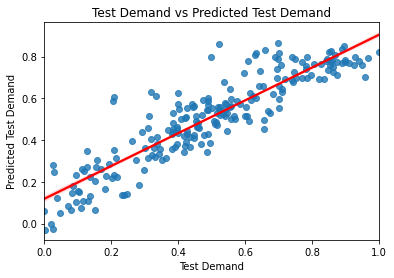

In [109]:
# plotting a Regression plot

plt.figure()
sns.regplot(x=y_test, y=y_test_pred_lr15, ci=68, fit_reg=True, line_kws={"color": "red"})
plt.title('Test Demand vs Predicted Test Demand')
plt.xlabel('Test Demand')
plt.ylabel('Predicted Test Demand')
plt.show()

#### Calculating R-squared for test data and evaluating against the train data R-squared

In [110]:
r_squared = r2_score(y_test, y_test_pred_lr15)
round(r_squared,2)

0.81

##### **Train R-squared score of the model lr_15 is :** 0.84
##### **Test R-squared score of the model lr_15 is :** 0.81

### **Conclusion**

#### From the above R-squared value, we can conclude that **Model lr_15** is fairly accurate in predicting demand and accomodates a variance of upto 81%

#### The equation of the best fitted line as per **Model lr_15** is:
  
------------------------------------------------------------------------------------------------------------------------------------------------------------------ 
|*cnt = 0.204 + (0.237 yr) + (0.039 workingday) + (0.421 temp) - (0.152 windspeed) - (0.076 season_spring) + (0.044 season_summer) + (0.107 season_winter) - (0.055 mnth_Dec)  - (0.049 mnth_Jan) - (0.064 mnth_Nov) + (0.056 mnth_Sep) + (0.055 weekday_Mon) - (0.080 weathersit_Cloudy) - (0.275 weathersit_Light Rain)*|
------------------------------------------------------------------------------------------------------------------------------------------------------------------

We can further infer that demand increases when 
* the day is warm
* it is summer/winter
* it is not spring
* its a Monday
* windspeeds are not too high
* weather is not cloudy or rainy

**In short, demand is high during warm and pleasant weather especially on Mondays**